In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from typing import Optional, Literal, Union

from help_spearman_proxy import *

## Differentiable proxy to Spearman corr

Based on the ["Fast Differentiable Sorting and Ranking"](https://arxiv.org/abs/2002.08871) article and [their implementation](https://github.com/google-research/fast-soft-sort/). Further inspiration for the implimentation of the Spearman corr taken from [here](https://forum.numer.ai/t/differentiable-spearman-in-pytorch-optimize-for-corr-directly/2287) and for the XGBoost custom objective function from [here](https://forum.numer.ai/t/custom-loss-functions-for-xgboost-using-pytorch/960).

One of the limitations of the **fast-soft-sort** implementations is that the soft rank is only once differenciable (seemingly the artifact of the implementation of the core functions in numpy). There is [another implementation](https://github.com/teddykoker/torchsort) of the same functions fully written in Pytorch and cpp. However, it requires installation of a cpp compiler and was not tested here due to the absence of admin rights on Windows.

## Test Spearman proxy objective function

In [2]:
rng = np.random.default_rng(1)

ytrue = rng.normal(size=(1, 10))
ypred = rng.normal(size=(1, 10))

print(ytrue)
print(ypred)
obj_spearman(ytrue, ypred)

[[ 0.34558419  0.82161814  0.33043708 -1.30315723  0.90535587  0.44637457
  -0.53695324  0.5811181   0.3645724   0.2941325 ]]
[[ 0.02842224  0.54671299 -0.73645409 -0.16290995 -0.48211931  0.59884621
   0.03972211 -0.29245675 -0.78190846 -0.25719224]]


(array([-0.04148875, -0.20659941, -0.04208716,  0.54291224, -0.24440162,
        -0.0728451 ,  0.27221832, -0.12769731, -0.05457294, -0.02543828]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

Custom evaluation (metric):

In [3]:
def spearman_eval(ypred: Union[np.ndarray, xgb.DMatrix], ytrue: Union[np.ndarray, xgb.DMatrix]) -> tuple[str, float]:
    """(exact) Spearman correlation metric."""
    if isinstance(ytrue, xgb.core.DMatrix):
        ytrue = ytrue.get_label()
    if isinstance(ypred, xgb.core.DMatrix):
        ypred = ypred.get_label()
    
    ytrue = ytrue.squeeze()
    ypred = ypred.squeeze()
    
    spear_corr = 1 - pd.DataFrame({"ytrue": ytrue, "ypred": ypred}).corr("spearman").iloc[0, 1]

    return ("Spear_corr", spear_corr)

Test Spearman corr evaluation function:

In [4]:
rng = np.random.default_rng(1)

ytrue = rng.normal(size=(1, 10))
ypred = rng.normal(size=(1, 10))

spearman_eval(ytrue, ypred)

('Spear_corr', 1.0424242424242425)

The following should evaluate to 0:

In [5]:
spearman_eval(ytrue, ytrue)

('Spear_corr', 0.0)

The following should evaluate to 2 (since 1 - (-1) = 2):

In [6]:
spearman_eval(ytrue, -ytrue)

('Spear_corr', 2.0)

## Load and prepare data

In [7]:
X_train_raw = pd.read_csv(r"../data/X_train.csv")
X_test_raw = pd.read_csv(r"../data/X_test.csv")
y_train = pd.read_csv(r"../data/y_train.csv")

Mask data for FR and DE:

In [8]:
mask_train_FR = X_train_raw["COUNTRY"] == "FR"
mask_test_FR = X_test_raw["COUNTRY"] == "FR"

Drop unsuded cols:

In [9]:
columns_to_drop = ["ID", "DAY_ID", "COUNTRY", "DE_FR_EXCHANGE", "FR_NET_IMPORT", "DE_NET_IMPORT"]

X_train = X_train_raw.drop(columns_to_drop, axis=1)
X_test = X_test_raw.drop(columns_to_drop, axis=1)
y_train = y_train["TARGET"]

Standartize vars:

In [10]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

Fill-in NAs:

In [11]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

Convert training data to DMatrix:

In [12]:
X_train_dm = xgb.DMatrix(data=X_train, label=y_train)
X_test_dm = xgb.DMatrix(data=X_test, label=None)

## Train booster with ordinary MSE obj and RMSE eval:

Cross validation:

In [13]:
params_xgb = dict(
    max_depth=2,
    eta=0.01,
    nthread=1,
    min_child_weight=10,
    objective="reg:squarederror"
    )

params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=1000,
    nfold=5,
    early_stopping_rounds=100,
    verbose_eval=10,
    seed=1
)

cv = \
    xgb.cv(
        params=params_xgb,
        **params_cv
        )

[0]	train-rmse:1.11042+0.01607	test-rmse:1.10916+0.06352
[10]	train-rmse:1.09203+0.01589	test-rmse:1.09396+0.06396
[20]	train-rmse:1.07641+0.01581	test-rmse:1.08108+0.06385
[30]	train-rmse:1.06291+0.01557	test-rmse:1.07010+0.06398
[40]	train-rmse:1.05138+0.01539	test-rmse:1.06085+0.06394
[50]	train-rmse:1.04149+0.01526	test-rmse:1.05331+0.06369
[60]	train-rmse:1.03295+0.01512	test-rmse:1.04725+0.06351
[70]	train-rmse:1.02574+0.01492	test-rmse:1.04254+0.06340
[80]	train-rmse:1.01954+0.01476	test-rmse:1.03874+0.06341
[90]	train-rmse:1.01411+0.01460	test-rmse:1.03573+0.06321
[100]	train-rmse:1.00934+0.01439	test-rmse:1.03343+0.06295
[110]	train-rmse:1.00514+0.01429	test-rmse:1.03167+0.06279
[120]	train-rmse:1.00124+0.01427	test-rmse:1.03021+0.06245
[130]	train-rmse:0.99773+0.01422	test-rmse:1.02917+0.06226
[140]	train-rmse:0.99463+0.01413	test-rmse:1.02820+0.06219
[150]	train-rmse:0.99181+0.01407	test-rmse:1.02768+0.06200
[160]	train-rmse:0.98921+0.01394	test-rmse:1.02736+0.06181
[170]	tr

In [14]:
cv

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.110419,0.016072,1.109162,0.063524
1,1.108443,0.016040,1.107527,0.063633
2,1.106485,0.016013,1.105949,0.063719
3,1.104578,0.015981,1.104366,0.063837
4,1.102680,0.015963,1.102796,0.063824
...,...,...,...,...
187,0.983230,0.013632,1.026932,0.061444
188,0.983048,0.013602,1.026927,0.061430
189,0.982837,0.013571,1.026999,0.061435
190,0.982663,0.013565,1.026929,0.061441


<Axes: >

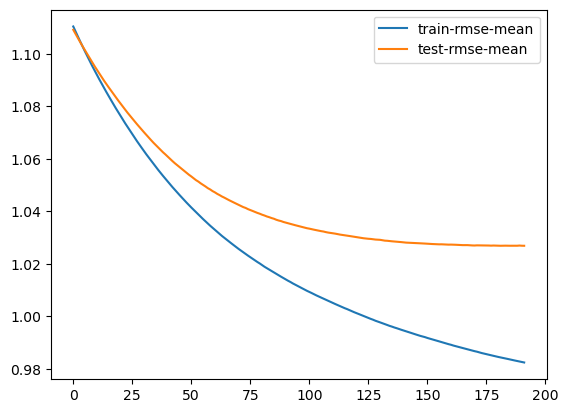

In [15]:
cv.iloc[:, [0, -2]].plot()

CV evaluation of the model on Spearman corr metric:

In [16]:
params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=cv.shape[0],
    nfold=5,
    early_stopping_rounds=None,
    verbose_eval=0,
    seed=1
)

cv = \
    xgb.cv(
        params=params_xgb,
        custom_metric=spearman_eval,
        **params_cv
        )

In [17]:
cv.iloc[-1, :]

train-rmse-mean          0.982474
train-rmse-std           0.013540
test-rmse-mean           1.026913
test-rmse-std            0.061404
train-Spear_corr-mean    0.673736
train-Spear_corr-std     0.010598
test-Spear_corr-mean     0.834566
test-Spear_corr-std      0.027367
Name: 191, dtype: float64

In [18]:
print(f"Spearman corr on val set = {100 * (1 - cv.iloc[-1, -2]):0.2f} +/- {100 * cv.iloc[-1, -1]:0.2f}")

Spearman corr on val set = 16.54 +/- 2.74


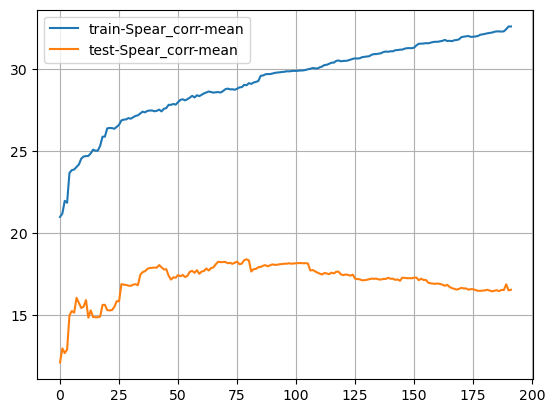

In [19]:
ax = (100 * (1 - cv.iloc[:, [-4, -2]])).plot()
ax.grid(which='both', axis='both')

In [20]:
model = xgb.train(
    params=params_xgb,
    dtrain=X_train_dm,
    num_boost_round=cv.shape[0]
)

In [21]:
y_train_hat = model.predict(X_train_dm)
y_test_hat = model.predict(X_test_dm)

Resulting Spearman corr on train set:

In [22]:
pd.DataFrame({"y_train": y_train, "y_train_hat": y_train_hat}).corr("spearman")

,y_train,y_train_hat
y_train,1.000000,0.315379
y_train_hat,0.315379,1.000000


## Train booster with Spearman proxy as obj and exact Spearman corr as eval:

Avoid cold start (xgboost starts by predicting mean, but Spearman corr for constant vectors is not defined):

In [28]:
params_xgb = dict(
    max_depth=1,
    eta=0.9,
    nthread=1,
    min_child_weight=10,
    objective="reg:squarederror"
    )

cs_model = xgb.train(params=params_xgb, dtrain=X_train_dm, num_boost_round=1)
cs_y_train = cs_model.predict(X_train_dm)
cs_y_test = cs_model.predict(X_test_dm)
print("pred std train set", cs_y_train.std())
print("pred std test set", cs_y_test.std())

pred std train set 0.15298736
pred std test set 0.15305726


In [29]:
X_train_dm = xgb.DMatrix(data=X_train, label=y_train, base_margin=cs_y_train)
X_test_dm = xgb.DMatrix(data=X_test, label=None, base_margin=cs_y_test)

In [60]:
params_xgb = dict(
    max_depth=2,
    eta=0.1,
    nthread=1,
    min_child_weight=10,
    colsample_bytree=1.,
    disable_default_eval_metric=True
    )

params_xgb["lambda"] = 1.

params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=3000,
    nfold=5,
    early_stopping_rounds=1000,
    verbose_eval=10,
    seed=1
    )

cv = \
    xgb.cv(
        params=params_xgb,
        obj=obj_spearman,
        custom_metric=spearman_eval,
        maximize=False,
        **params_cv
        )

[0]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[10]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[20]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[30]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[40]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[50]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[60]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[70]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[80]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[90]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[100]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[110]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[120]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[130]	train-Spear_corr:0.78853+0.00714	test-Spear_corr:0.78317+0.03153
[140]	train-Spear

In [57]:
cv

,train-Spear_corr-mean,train-Spear_corr-std,test-Spear_corr-mean,test-Spear_corr-std
0,0.788531,0.007136,0.78317,0.031527


In [52]:
print(f"Spearman corr on val set: {100 * (1 - cv.iloc[-1, 2]):.1f} +/- {100 * cv.iloc[-1, 3]:.1f}")

Spearman corr on val set: 21.7 +/- 3.2


<Axes: >

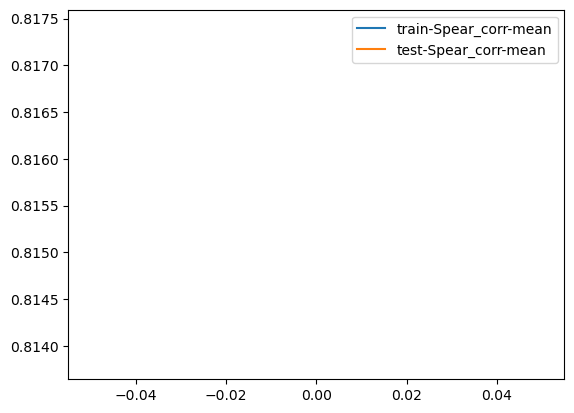

In [42]:
cv.iloc[:, [0, -2]].plot()

In [43]:
params_xgb = dict(
    max_depth=2,
    eta=.1,
    nthread=1,
    min_child_weight=10,
    disable_default_eval_metric=True
    )

params_cv = dict(
    dtrain=X_train_dm,
    num_boost_round=cv.shape[0],
    nfold=5,
    early_stopping_rounds=None,
    verbose_eval=0,
    seed=1
    )

cv = \
    xgb.cv(
        params=params_xgb,
        obj=obj_spearman,
        custom_metric=spearman_eval,
        maximize=False,
        **params_cv
        )

In [44]:
cv.iloc[-1, :]

train-Spear_corr-mean    0.817416
train-Spear_corr-std     0.008524
test-Spear_corr-mean     0.813822
test-Spear_corr-std      0.038183
Name: 0, dtype: float64

In [45]:
model = xgb.train(
    params=params_xgb,
    dtrain=X_train_dm,
    num_boost_round=cv.shape[0]
)

In [29]:
# import io
# import json

# with io.StringIO() as fout:
#     model.dump_model(fout, fmap='', with_stats=True, dump_format='text')
#     fout.seek(0)
#     model_js = fout.getvalue()
# print(model_js)

In [46]:
y_train_hat = model.predict(X_train_dm)
y_test_hat = model.predict(X_test_dm)

Resulting Spearman corr on train set:

In [47]:
pd.DataFrame({"y_train": y_train, "y_train_hat": y_train_hat}).corr("spearman")

,y_train,y_train_hat
y_train,1.000000,0.226744
y_train_hat,0.226744,1.000000
